# Are there differences in car crash rates by county?

In [3]:
import numpy as np
import pandas as pd
import json
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
def plot_choroplethmap(counties, fips, value, value_min, value_max, text, title):
    fig = go.Figure(go.Choroplethmapbox(geojson=counties, locations=fips, z=value,
                                    colorscale="Viridis", zmin=value_min, zmax = value_max,
                                    marker_opacity=0.8, marker_line_width=1, 
                                    text=text))

    fig.update_layout(mapbox_style="carto-positron",
                      mapbox_zoom=4.3, mapbox_center = {"lat": 37.5, "lon": -120})
    fig.update_layout(margin={"r":150,"t":30,"l":150,"b":0}, 
                      title={"text":title})
    fig.show()

In [5]:
# relative path to data & figures directory
from paths import DATA_PATH, FIGURES_PATH

In [8]:
# Organizing the dataset and abtract features we want
county_data_2019 = pd.read_excel(f"{DATA_PATH}/location_2019.xlsm", header=2, sheet_name="Table 8A - Crashes")
county_data_2019 = county_data_2019[county_data_2019["County"].notna()].reset_index()
county_data_2019["Total Crashes"] = county_data_2019.iloc[:, 4:7].sum(axis=1)
county_data_2019 = county_data_2019.iloc[:, [1, 7, 8, 15]].drop(58)

fatality_df = pd.read_excel(f"{DATA_PATH}/location_2019.xlsm", header=3, sheet_name="Table 8I").drop(58)
county_data_2019["Total Fatal"] = fatality_df["Total"]

injury_df = pd.read_excel(f"{DATA_PATH}/location_2019.xlsm", header=3, sheet_name="Table 8K").drop(58)
county_data_2019["Total Injury"] = injury_df["Total"]

alcohol_df = pd.read_excel(f"{DATA_PATH}/location_2019.xlsm", header=4, sheet_name="Table 8L")
county_data_2019["Alcohol Involved Crashes"] = alcohol_df.fillna(0).iloc[0:58:, [9, 10]].sum(axis=1).astype(int)

population_df = pd.read_excel(f"{DATA_PATH}/location_2019.xlsm", header=4, sheet_name="Table 8B").iloc[0:58, 4].astype(int)
county_data_2019["Population"] = population_df

In [9]:
# Display the first 10 rows of the dataset
county_data_2019.head(10)

,County,Alcohol Involved Fatal,Alcohol Involved Injury,Total Crashes,Total Fatal,Total Injury,Alcohol Involved Crashes,Population
0,Alameda,28,655,22768,96,10441,469,1668965
1,Alpine,0,4,77,2,66,1,1123
2,Amador,4,38,521,16,276,29,37724
3,Butte,9,143,2226,34,1262,130,214532
4,Calaveras,4,45,598,11,305,44,44403
5,Colusa,1,21,352,12,205,22,22045
6,Contra Costa,27,492,12195,77,5982,383,1147269
7,Del Norte,1,19,285,11,217,20,27207
8,El Dorado,11,103,1644,29,861,96,188818
9,Fresno,34,305,7848,135,4247,297,1018437


In [10]:
# Load the fips code of each county in California
county_fips = pd.read_excel(f"{DATA_PATH}/county_fips.xlsx")
county_fips.head(10)

,county,fips
0,Alameda,1
1,Alpine,3
2,Amador,5
3,Butte,7
4,Calaveras,9
5,Colusa,11
6,Contra Costa,13
7,Del Norte,15
8,El Dorado,17
9,Fresno,19


In [11]:
# Combine the county fips with the California State fips to create the full fips
cal_fip = "06"
def create_full_fip(county_fip, state_fip):
    if len(county_fip) > 3:
        raise("Invalid county_fip")
    while len(county_fip) < 3:
        county_fip = "0" + county_fip
        
    return state_fip + county_fip

county_fips["fips"] = county_fips["fips"].astype(str)
county_fips["fips"] = county_fips["fips"].apply(lambda fips: create_full_fip(fips, cal_fip))
county_fips = county_fips.rename(columns={"county":"County"})
county_fips.head()

,County,fips
0,Alameda,06001
1,Alpine,06003
2,Amador,06005
3,Butte,06007
4,Calaveras,06009


In [12]:
# Organize the dataset again by rearanging column order
county_data_2019 = pd.merge(county_fips, county_data_2019, on="County")
county_data_2019 = county_data_2019.iloc[:, [0, 1, 8, 4, 5, 6, 7, 2, 3]]
county_data_2019.head(10)

,County,fips,Population,Total Crashes,Total Fatal,Total Injury,Alcohol Involved Crashes,Alcohol Involved Fatal,Alcohol Involved Injury
0,Alameda,06001,1668965,22768,96,10441,469,28,655
1,Alpine,06003,1123,77,2,66,1,0,4
2,Amador,06005,37724,521,16,276,29,4,38
3,Butte,06007,214532,2226,34,1262,130,9,143
4,Calaveras,06009,44403,598,11,305,44,4,45
5,Colusa,06011,22045,352,12,205,22,1,21
6,Contra Costa,06013,1147269,12195,77,5982,383,27,492
7,Del Norte,06015,27207,285,11,217,20,1,19
8,El Dorado,06017,188818,1644,29,861,96,11,103
9,Fresno,06019,1018437,7848,135,4247,297,34,305


In [13]:
# Import json file that contains all geographical shapes of counties in the US
counties = json.load(open(f"{DATA_PATH}/CA-flips.json"))
    
# Select only the countries in California
CA_counties = []
for county in counties["features"]:
    if county["properties"]["STATE"] == "06":
        CA_counties.append(county)

counties["features"] = CA_counties

In [15]:
# Save the json file for California counties for main notebook
with open(f"{DATA_PATH}/CA-flips.json", "w") as file:
    file.write(json.dumps(counties))

In [16]:
# plot collision count by county choroplethmap
plot_choroplethmap(counties=counties, 
                   fips=county_data_2019["fips"], 
                   value=county_data_2019["Total Crashes"].tolist(), 
                   value_min=0, 
                   value_max=20000, 
                   text=county_data_2019["County"].tolist(), 
                   title="Collision Count by County in California")

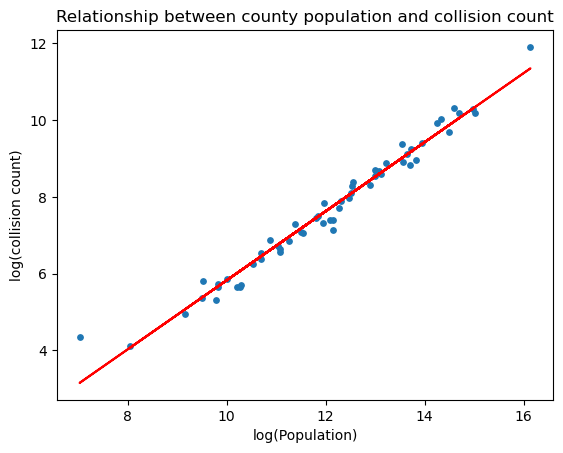

In [17]:
# Take the log transformation of both variables
x = np.log(county_data_2019["Population"])
y = np.log(county_data_2019["Total Crashes"])

# Plot the scatter plot of log(population) vs log(#incidence per 1000 capita)
plt.scatter(x, y, s=15)
plt.ylabel('total')

# Find the best-fit line
a, b = np.polyfit(x, y, 1)
plt.plot(x, a*x+b, color="red")
plt.title("Relationship between county population and collision count")
plt.xlabel("log(Population)")
plt.ylabel("log(collision count)")
plt.savefig(f"{FIGURES_PATH}/scatter3_1.png")
plt.show()

In [18]:
# plot collision frequency (per 1000 capita) by county choroplethmap
county_data_2019["Crashes per 1000 capita"] = county_data_2019["Total Crashes"].astype(int).divide(county_data_2019["Population"].astype(int))*1000
plot_choroplethmap(counties=counties, 
                   fips=county_data_2019["fips"], 
                   value=county_data_2019["Crashes per 1000 capita"].tolist(), 
                   value_min=5, 
                   value_max=20, 
                   text=county_data_2019["County"].tolist(), 
                   title="Collision Count per 1000 Capita by County in California")


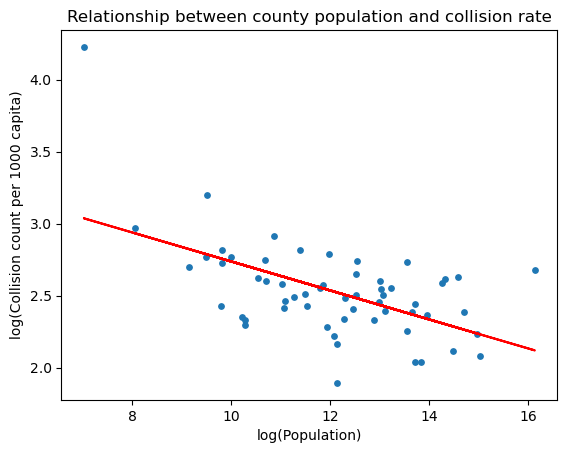

In [19]:
# Take the log transformation of both variables
x = np.log(county_data_2019["Population"])
y = np.log(county_data_2019["Crashes per 1000 capita"])

# Plot the scatter plot of log(population) vs log(#incidence per 1000 capita)
plt.scatter(x, y, s=15)
plt.ylabel('total')

# Find the best-fit line
a, b = np.polyfit(x, y, 1)
plt.plot(x, a*x+b, color="red") 
plt.title("Relationship between county population and collision rate")
plt.xlabel("log(Population)")
plt.ylabel("log(Collision count per 1000 capita)")
plt.savefig(f"{FIGURES_PATH}/scatter3_2.png")

plt.show()

In [20]:
# plot fatal rate by county choroplethmap
county_data_2019["Overall Fatal Rate"] = county_data_2019["Total Fatal"].astype(int).divide(county_data_2019["Total Crashes"].astype(int))*100
plot_choroplethmap(counties=counties, 
                   fips=county_data_2019["fips"], 
                   value=county_data_2019["Overall Fatal Rate"].tolist(), 
                   value_min=0, 
                   value_max=3, 
                   text=county_data_2019["County"].tolist(), 
                   title="Collision Fatal Rate by County in California")

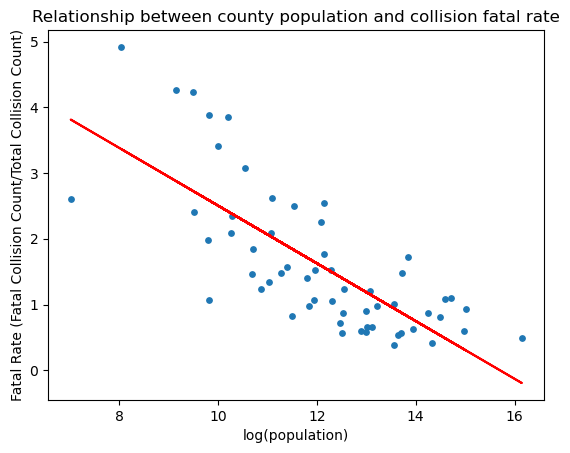

In [21]:
import matplotlib.pyplot as plt

# Take the log transformation of population
x = np.log(county_data_2019["Population"])
y = county_data_2019["Overall Fatal Rate"]

# Plot the scatter plot of log(population) vs Fatal Rate
plt.scatter(x, y, s=15)
plt.ylabel('total')

# Find the best-fit line
a, b = np.polyfit(x, y, 1)
plt.plot(x, a*x+b, color="red") 
plt.title("Relationship between county population and collision fatal rate")
plt.xlabel("log(population)")
plt.ylabel("Fatal Rate (Fatal Collision Count/Total Collision Count)")
plt.savefig(f"{FIGURES_PATH}/scatter3_3.png")

plt.show()

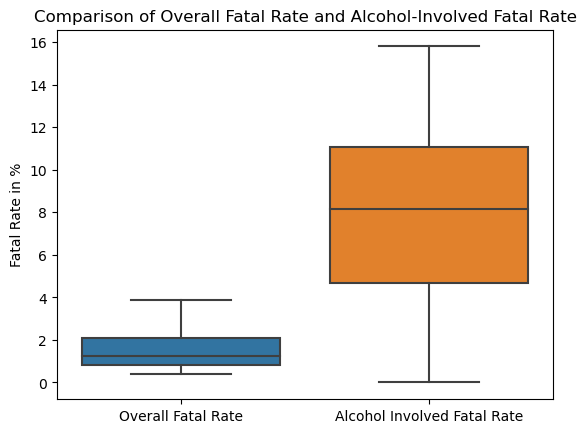

In [22]:
# use barplot to compare the distribution of overall fatal rate and alcohol-involved fatal rate
county_data_2019["Alcohol Involved Fatal Rate"] = county_data_2019["Alcohol Involved Fatal"].divide(county_data_2019["Alcohol Involved Crashes"])*100

sns.boxplot(data=county_data_2019.loc[:, ["Overall Fatal Rate", "Alcohol Involved Fatal Rate"]], showfliers = False).set(
    ylabel='Fatal Rate in %',
    title="Comparison of Overall Fatal Rate and Alcohol-Involved Fatal Rate"
);
plt.savefig(f"{FIGURES_PATH}/boxplot3_4.png")

In [23]:
# Save the dataset for main notebook
county_data_2019.to_csv(f"{DATA_PATH}/county_data_2019.csv")